# Task 1 Constructing the matrix X

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix


In [2]:
def construct_X(M, alphas, Np = None):
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
    i_indices = []
    j_indices = []
    weights = []

    N = len(alphas) * Np
    D = M * M
    X = coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype = numpy.float32),

    return X

In [3]:
def construct_X(M, alphas, Np=None):
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
    
    h = 1  # Pixel distance
    x = np.linspace(-(M-1)/2, (M-1)/2, M)
    y = np.linspace(-(M-1)/2, (M-1)/2, M)
    Cx, Cy = np.meshgrid(x, y)
    C = np.vstack([Cx.ravel(), Cy.ravel()])
    
    i_indices = []
    j_indices = []
    weights = []
    
    for alpha in alphas:
        theta = np.deg2rad(alpha)
        R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        p = R @ C
        p[0, :] += (Np-1) / 2
        
        alpha_idx = np.where(alphas == alpha)[0][0]
        
        for j in range(C.shape[1]):
            pj = p[:, j]
            sensor_idx = int(np.floor(pj[0]))
            if 0 <= sensor_idx < Np-1:
                i_indices.append(sensor_idx + (alpha_idx * Np))
                j_indices.append(j)
                weights.append(1 - (pj[0] - sensor_idx))
                
                i_indices.append(sensor_idx + 1 + (alpha_idx * Np))
                j_indices.append(j)
                weights.append(pj[0] - sensor_idx)
    
    X = coo_matrix((weights, (i_indices, j_indices)), shape=(len(alphas) * Np, M * M), dtype=np.float32)
    
    # Debug: Check the shape and some values of X
    print(f"X shape: {X.shape}")
    print(f"Non-zero entries: {X.nnz}")
    print(f"Sample indices: {i_indices[:10]}, {j_indices[:10]}")
    print(f"Sample weights: {weights[:10]}")
    
    return X


In [4]:
directory = 'hs_tomography'

# M = 77 for small dataset 195 for bigger dataset
M = 77

# load the dataset
file_name_alpha = 'alphas_'+str(M)+'.npy'
file_name_y = 'y_'+str(M)+'.npy'

data_alpha = np.load(os.path.join(directory, file_name_alpha))
data_y = np.load(os.path.join(directory, file_name_y))
print("The shape of alpha: ", data_alpha.shape,'\n', "The shape of y:", data_y.shape)


# call function to construct X
X = construct_X(M, data_alpha)

#print(X)

The shape of alpha:  (90,) 
 The shape of y: (9810,)
X shape: (9810, 5929)
Non-zero entries: 1067220
Sample indices: [15, 16, 15, 16, 15, 16, 15, 16, 15, 16], [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
Sample weights: [0.6574038605596471, 0.34259613944035294, 0.639951454122361, 0.360048545877639, 0.6224990476850749, 0.3775009523149251, 0.605046641247796, 0.39495335875220405, 0.5875942348105099, 0.4124057651894901]


Range of values in X_dense: min=0.0, max=1.0


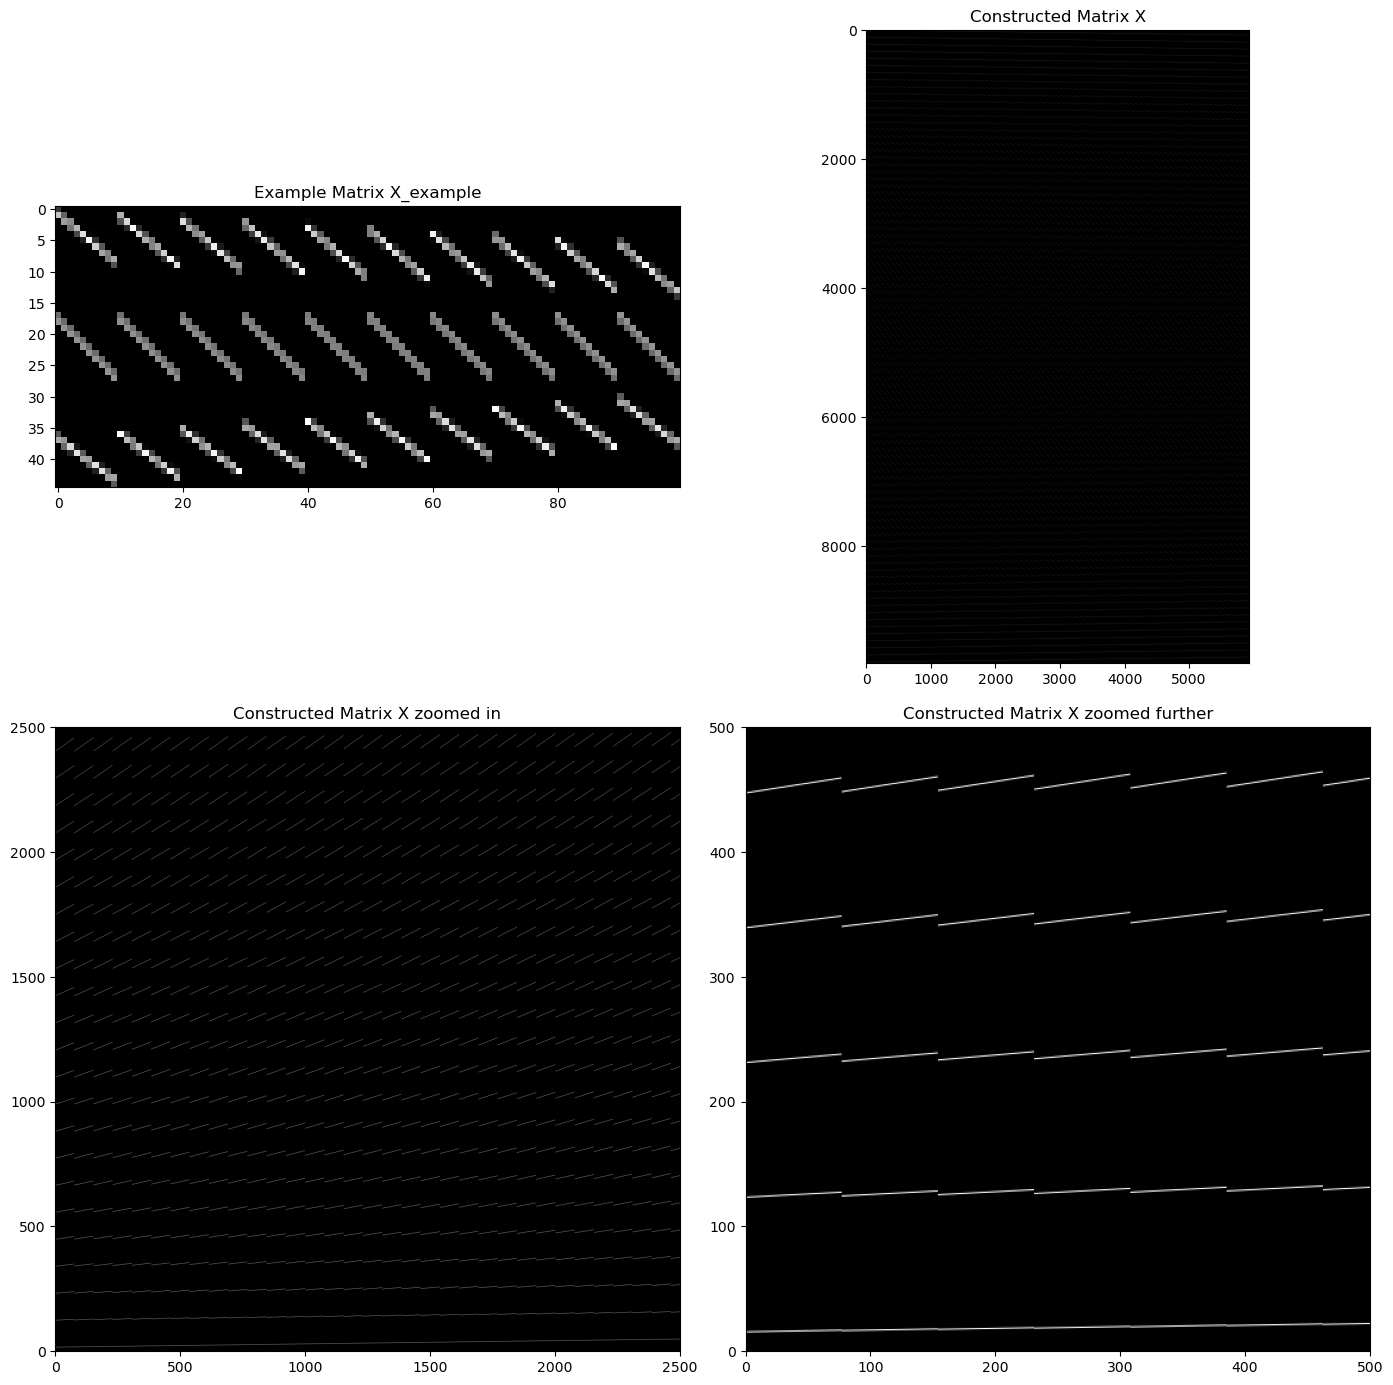

In [20]:
# Load the example matrix
X_example = np.load('hs_tomography/X_example.npy')

# Convert sparse matrix X to dense format
X_dense = X.toarray()

# Check the range of values in X_dense
print(f"Range of values in X_dense: min={X_dense.min()}, max={X_dense.max()}")

# Visualize both matrices with adjusted colormap limits if necessary
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Visualize example matrix
axes[0,0].imshow(X_example, cmap='gray')
axes[0,0].set_title('Example Matrix X_example')

# Visualize constructed matrix with colormap adjustment
axes[0,1].imshow(X_dense, cmap='gray', vmin=0, vmax=np.max(X_dense))
axes[0,1].set_title('Constructed Matrix X')
#axes[1].set_xlim(0,2500)
#axes[1].set_ylim(0,2500)

#Zoom in on the costructed matrix
axes[1,0].imshow(X_dense, cmap='gray', vmin=0, vmax=np.max(X_dense))
axes[1,0].set_title('Constructed Matrix X zoomed in')
axes[1,0].set_xlim(0,2500)
axes[1,0].set_ylim(0,2500)

axes[1,1].imshow(X_dense, cmap='gray', vmin=0, vmax=np.max(X_dense))
axes[1,1].set_title('Constructed Matrix X zoomed further')
axes[1,1].set_xlim(0,500)
axes[1,1].set_ylim(0,500)

plt.tight_layout()
plt.show()


# Task 2 Recovering the image

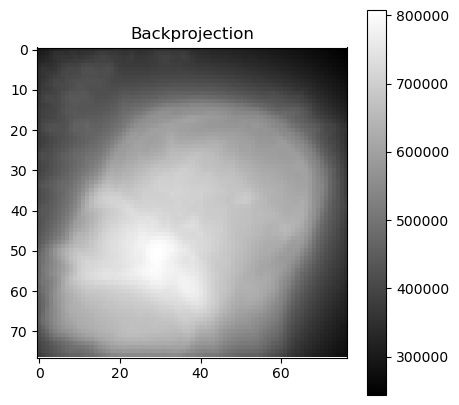

In [18]:
def backprojection(X, y):
    return X.T @ y

# Compute the backprojection
beta_backprojection = backprojection(X, data_y)

# Visualize the backprojection result
plt.figure(figsize=(5, 5))
plt.imshow(beta_backprojection.reshape(M, M), cmap='gray')
plt.title('Backprojection')
plt.colorbar()
plt.show()

# Tast 3 Minimizing the radiation dose

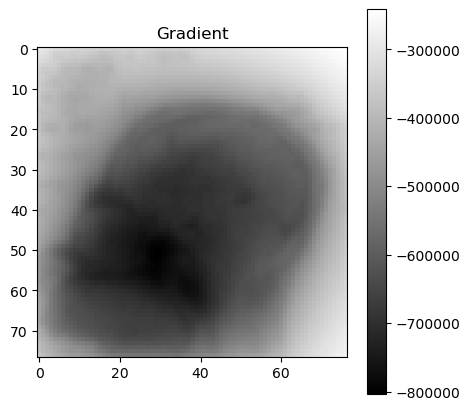

In [19]:
def gradient(X, y, beta):
    return X.T @ (X @ beta - y)

# Example tomogram for gradient computation
beta_example = np.random.rand(M * M)

# Compute the gradient
grad = gradient(X, data_y, beta_example)


# Visualize the gradient
plt.figure(figsize=(5, 5))
plt.imshow(grad.reshape(M, M), cmap='gray')
plt.title('Gradient')
plt.colorbar()
plt.show()